#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [7]:
mp = 96 #  (submerged) [kg/m]

In [8]:
# q0=[i for i in range(12)]
max_t = 2 # 10 #600  
dt = 0.5
t=np.arange(0,max_t,dt)
ds = 0.025
print(t)

[0.  0.5 1.  1.5]


In [9]:
node_N=3

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
from sympy import *

In [20]:
rng = np.random.default_rng()

In [21]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [22]:
def C1(dx,dy,dz):
    return np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])

In [23]:
startTime1 = datetime.now()
C1(dx,dy,dz)
print(datetime.now() - startTime1)

0:00:00.000253


In [24]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [25]:
def fD(dx,dy,dz,DT):
#     print(dx)
#     print(C1(dx,dy,dz).shape)
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz))

In [26]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT)
print(datetime.now() - startTime1)

0:00:00.001818


In [27]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [28]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [29]:
I=np.identity(3)

In [30]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT))
print(datetime.now() - startTime1)

0:00:00.000339


In [31]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [32]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [33]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [34]:
DR=np.diag(diag_DR) 

In [35]:
dI= 0.69# Inner diameter of pipe, [m]

In [36]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [37]:
Ar

0.08091250419136858

In [38]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)]).reshape(3, node_N)

In [39]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [40]:
from numpy import linalg as LA

In [41]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [42]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [43]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [44]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000207


In [45]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.000789


In [46]:
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1])).reshape(3,node_N)

In [47]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.000736


In [48]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [49]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [50]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [51]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [52]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002309


In [53]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [54]:
# Fossen paper, equation (12)

In [55]:
# φ,θ,ψ=1,2,3

In [56]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [57]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000120


In [58]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [59]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [60]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [61]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [62]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000936


In [63]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [64]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [65]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [66]:
def ne_(x,y,z,dx,dy,dz):
#     print(fg_e)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
#     return -fg_e-fD(dx,dy,dz,DT)-sigma(x,y,z)
    return -fg_e-fD(dx,dy,dz,DT)

In [67]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [68]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000597


In [69]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz)
print(datetime.now() - startTime1)

0:00:00.000363


In [70]:
Re_b(Ret).shape

(3, 3, 3)

In [71]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [72]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000153


In [73]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
                  [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
                  [-np.sin(θ),0,1]])

In [74]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [75]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000412


In [76]:
def ωe(φ,θ,ψ):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
    B=np.array([φ,θ,ψ]).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [77]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [78]:
startTime1 = datetime.now()
ωe(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.000576


In [79]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [80]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [81]:
def me(φ,θ,ψ,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [82]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,Ret)
print(datetime.now() - startTime1)

0:00:00.000635


In [83]:
me_

array([[-9.40773382e+06,  1.45557216e+11,  1.38136057e+07],
       [-2.35767561e+10,  1.43732723e+10, -3.80052956e+09],
       [-2.62244822e+09,  4.62900264e+08,  3.81530675e+10]])

In [84]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [85]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [86]:
ne_(x,y,z,dx,dy,dz)

array([[ -107.1906259 , -1028.82206489,  -206.11554529],
       [ -413.97454649,   127.65572692,  -178.43808124],
       [  625.30448038,   -34.50286101,   -22.8770408 ]])

In [87]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [88]:
d_s(a,b,c,x,y,z)

array([[       0.        , -2487361.09853799,   660463.90192712],
       [       0.        ,   468749.63841887,  -135295.90887788],
       [       0.        ,  -115842.20762785,  1225240.19195936]])

In [89]:
Re_b(Ret).shape

(3, 3, 3)

In [90]:
ne_(x,y,z,dx,dy,dz).T

array([[ -107.1906259 ,  -413.97454649,   625.30448038],
       [-1028.82206489,   127.65572692,   -34.50286101],
       [ -206.11554529,  -178.43808124,   -22.8770408 ]])

In [91]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([  14.93586033,   48.54712938, -121.92794379]),
 array([-27.88085109, -37.43216703, 196.13286117]),
 array([ 0.42804902, -1.32612738,  0.36502782]),
 numpy.ndarray,
 array([-0.94405884,  0.12404947, -0.40299937]))

In [92]:
ne_(x,y,z,dx,dy,dz).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz).T)

array([[ 518.1940792 , -801.1982973 ,  806.47342372],
       [-566.38950791, -744.36455218,  284.39843456],
       [-131.43884583, -329.95044471, -238.08512643]])

### Catenary

In [93]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [94]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [95]:
Fx_0=82945396

In [96]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [97]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [98]:
delta_x=horizontal_length/(node_N-1)

In [99]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [100]:
x0,z0

([0.0, 5526.34242223081, 11052.68484446162],
 [0.0, 173.43471225842703, 694.4218951076863])

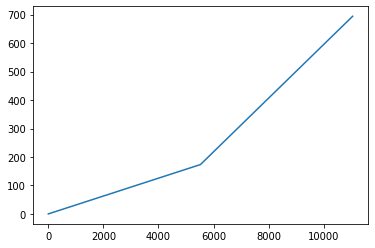

In [101]:
plt.plot(x0, z0)
plt.show()

In [102]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [103]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==7 or j==9 or j==11:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [104]:
q0

array([    0.        ,  5526.34242223, 11052.68484446,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,   173.43471226,   694.42189511,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

### Vessel

In [105]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)
    def tau(self, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [106]:
V=VesselSemisub()

In [107]:
dη=np.array([1,2,3,4,5,6])
ddη=np.array([1.3,2.4,3.5,4.6,5.7,6.8])

In [108]:
tau_force = V.tau(dη, ddη)

In [109]:
tau_force.shape

(6,)

In [110]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [111]:
t

array([0. , 0.5, 1. , 1.5])

In [112]:
sampleTime = 0.01                 # sample time [seconds]
N = 50_000                         # number of samples

In [113]:
N

50000

In [114]:
vehicle=semisub('DPcontrol',100.,100.,40.0,0,0) 

In [115]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [116]:
simData.shape

(50001, 24)

In [117]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=0.01

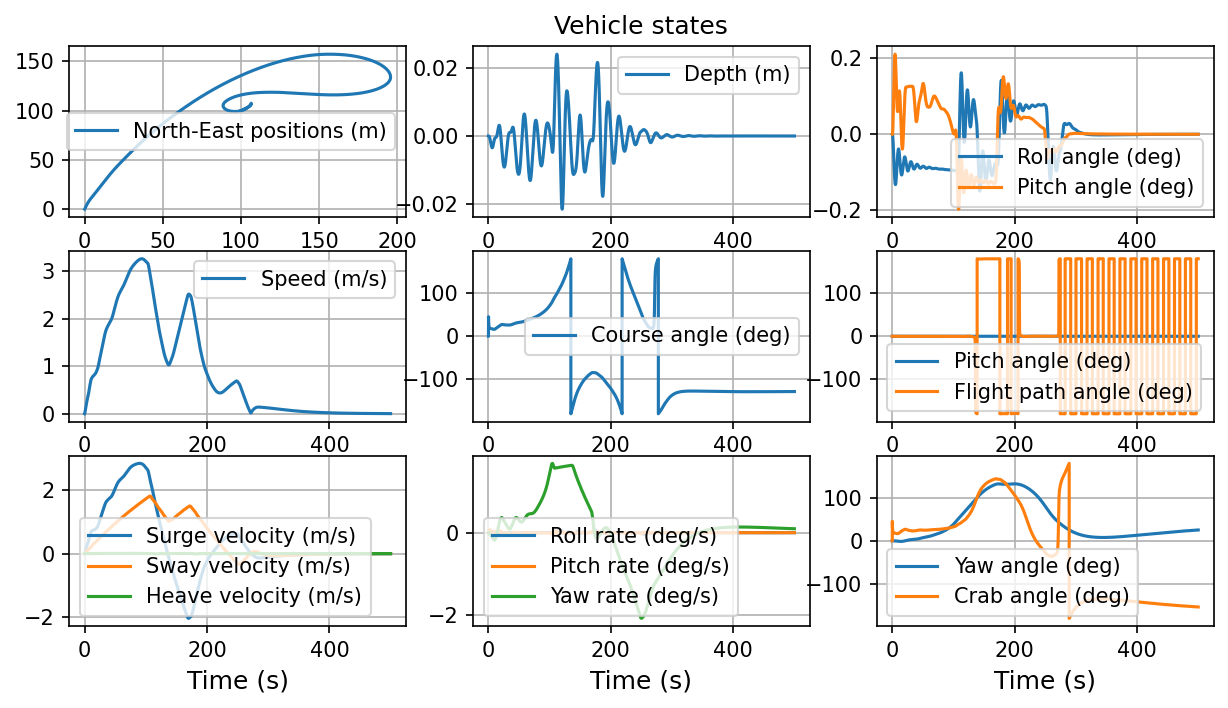

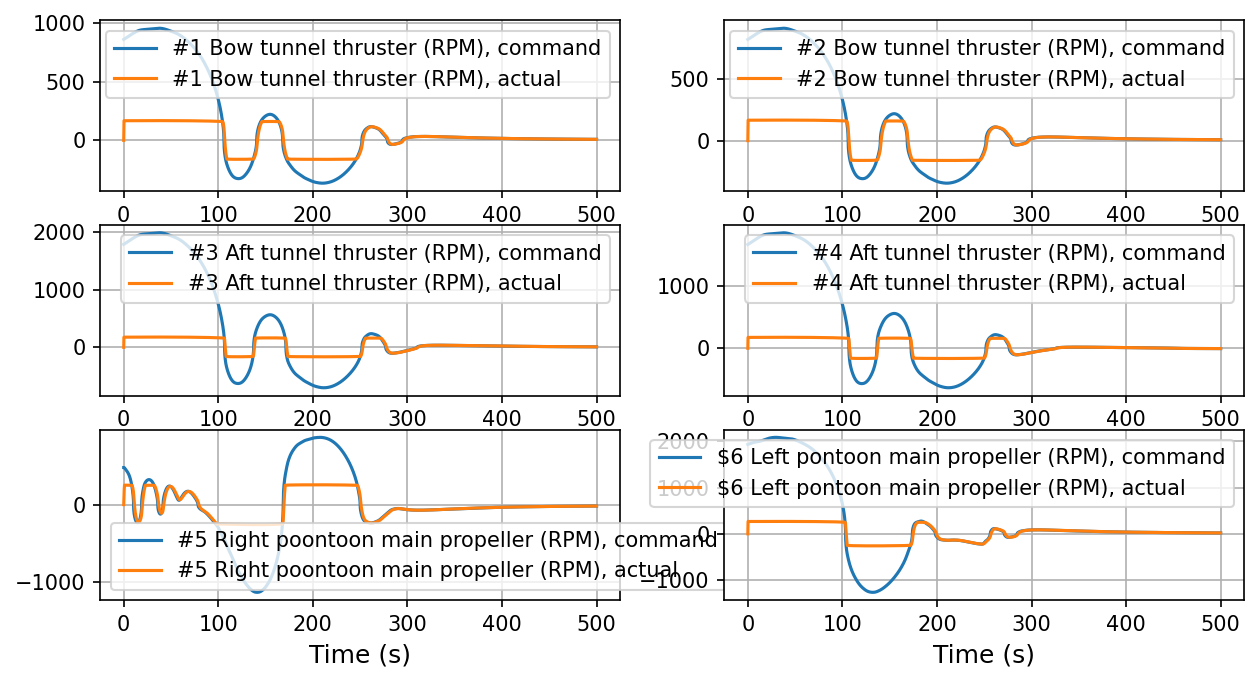

In [118]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [119]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'                  # browser for visualization of animated GIF

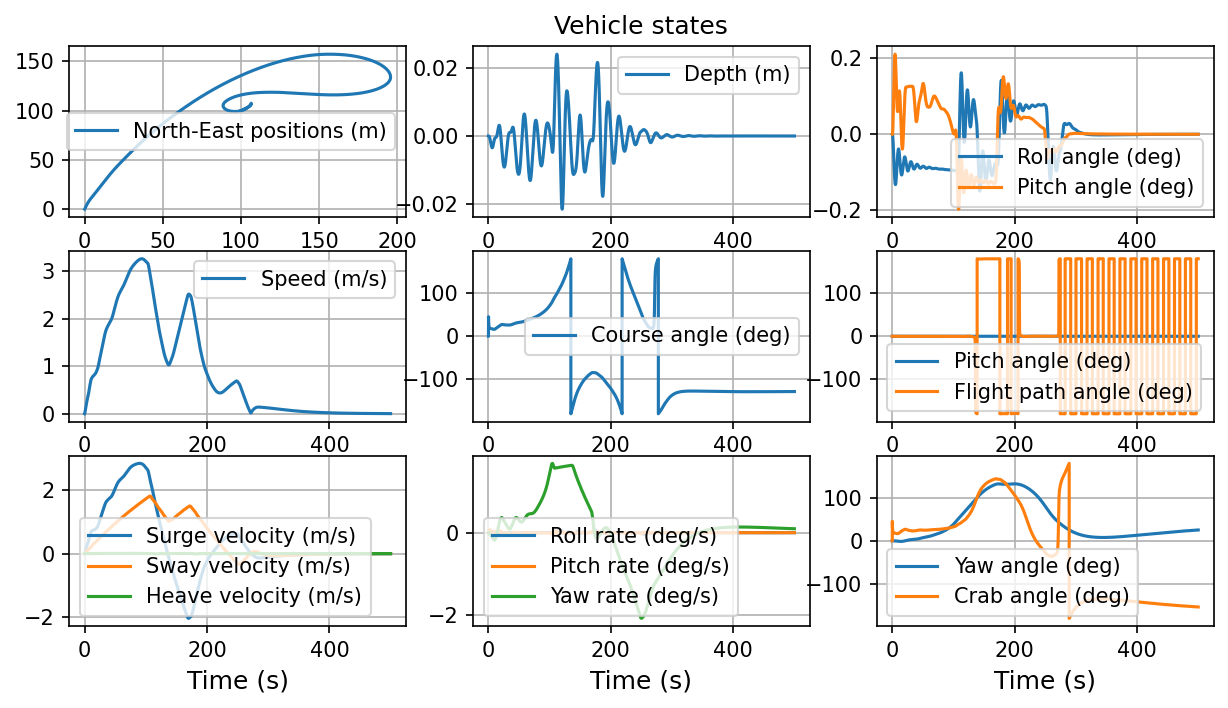

In [120]:
plotVehicleStates(simTime, simData, 3)

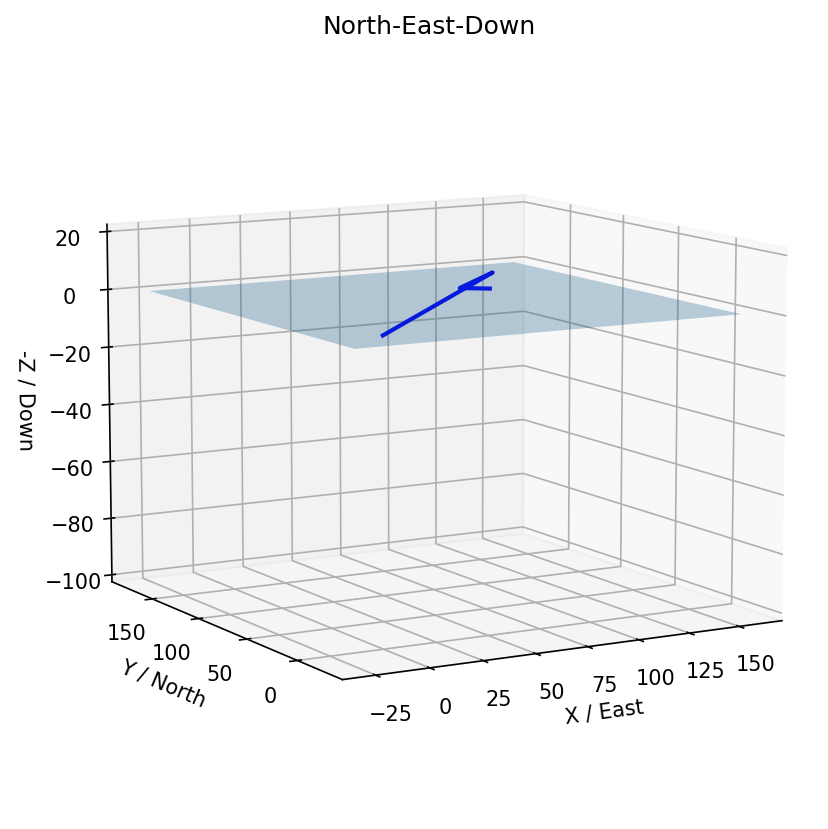

In [121]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [122]:
# class Time:
#     def __init__(self):
#         self.time=0

In [123]:
# co=Time()

In [124]:
# t

In [125]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [126]:
# simData[1]

In [127]:
simD=np.insert(simData, 0, simData[0], axis=0)

In [128]:
diff=np.diff(simD,axis=0)

In [129]:
V=VesselSemisub()

In [130]:
thres =0.1

In [131]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [132]:
SD0=simD[:, 0]
SD1=simD[:, 1]
SD2=simD[:, 2]
SD3=simD[:, 3]
SD4=simD[:, 4]
SD5=simD[:, 5]
SD6=simD[:, 6]
SD7=simD[:, 7]
SD8=simD[:, 8]
SD9=simD[:, 9]
SD10=simD[:, 10]
SD11=simD[:, 11]
Diff6=diff[:, 6]
Diff7=diff[:, 7]
Diff8=diff[:, 8]
Diff9=diff[:, 9]
Diff10=diff[:, 10]
Diff11=diff[:, 11]

In [133]:
def feedback(Q):
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    K = 2e8 # feedback gain
    u_x = -K * x 
    u_y = -K * y
    u_z = -K * z 
    u_dx = -K * dx 
    u_dy = -K * dy 
    u_dz = -K * dz 
    u_φ = -K * φ 
    u_θ = -K * θ
    u_ψ = -K * ψ 
    u_dφ= -K * dφ 
    u_dθ = -K * dθ 
    u_dψ = -K * dψ 
    return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [134]:
class Time:
    def __init__(self,up):
        self.my_max = sampleTime*N
        self.my_time=0
        self.my_n=0
        self.my_update=up

In [135]:
co=Time(1e-3)

In [136]:
def grayscott1d(Q,p,t):
#     Q,t=np.array(Q),np.array(t)
#     print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
#     co.time += 0.1
    if co.my_time%co.my_max==0:
        co.my_n+=1
        
    co.my_time+=(-1)**co.my_n*co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
    idx = find_nearest(np.array(ans_t),  abs(co.my_time)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
    x_ve = SD0[idx]
    y_ve = SD1[idx]
    z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(simData[:, 3][idx]))
#     theta_ve = R2D(ssa(simData[:, 4][idx]))
#     psi_v = R2D(ssa(simData[:, 5][idx]))
#     phi_ve = ssa(SD3[idx])
#     theta_ve = ssa(SD4[idx])
#     psi_v = ssa(SD5[idx])
    
    u_ve = SD6[idx]
    v_ve = SD7[idx]
    w_ve = SD8[idx]
    p_ve = SD9[idx]
    q_ve = SD10[idx]
    r_ve = SD11[idx]
    
    du_ve = Diff6[idx]/sampleTime
    dv_ve = Diff7[idx]/sampleTime
    dw_ve = Diff8[idx]/sampleTime
    dp_ve = Diff9[idx]/sampleTime
    dq_ve = Diff10[idx]/sampleTime
    dr_ve = Diff11[idx]/sampleTime
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
    
    tau_force = V.tau(dη, ddη)
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]
#     print( x[-1], y[-1], z[-1])
#     x[0]=0
#     y[0]=0
#     z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
    Z0=np.zeros((node_N,3))
    Z0[-1]=tau_force[:3]
    Z1 = d_s(a,b,c,x,y,z).T
    Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz).T)
    Z=Z1 + Z2 + Z0
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
    
    ddx,ddy, ddz = (1/Ws*Z).T
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
    C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), np.array([dφ,dθ,dψ]).astype(np.float32).T)))
        
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
    C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
    C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
        
    C0=np.zeros((node_N,3))
    C0[-1]=tau_force[3:]
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    B =(-C1-C2+C3+C4+C5+C0)
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
    A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
    A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
        
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T 
#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
# #     print(ans_ψ)

#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0) 
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)
    return A1111+feedback(Q)

In [137]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [138]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [139]:
# q0.shape

In [140]:
# import numpy as np

In [141]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [142]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [143]:
# grayscott1d(4,q0)

In [144]:
# grayscott1d(4,q0).shape

In [145]:
tspan = (0., 1.)

In [146]:
startTime1 = datetime.now()
prob = de.ODEProblem(grayscott1d, q0, tspan)
us = de.solve(prob)
print(datetime.now() - startTime1)

1:18:18.831591


In [147]:
fin=us.u

In [148]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [149]:
# !pip3 install diffeqpy

In [150]:
# node_N

In [151]:
# t

In [152]:
# plt.plot(us.t,us.u)
# plt.show()

In [153]:
# node_N

In [154]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [155]:
# fin

In [156]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


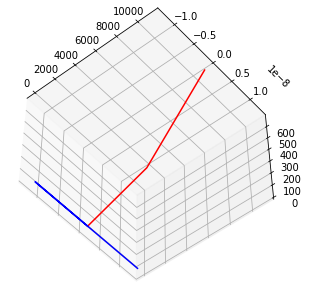

In [172]:
fig=plt.figure(figsize=(13,5))
ax = fig.gca(projection='3d')

X0=fin[0][[i for i in range(0,node_N)]]
Y0=fin[0][[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0][[i for i in range(4*node_N,5*node_N)]]
X=fin[-1][[i for i in range(0,node_N)]]
Y=fin[-1][[i for i in range(2*node_N,3*node_N)]]
Z=fin[-1][[i for i in range(4*node_N,5*node_N)]]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-50,-50)
# ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [173]:
X,Y,Z

(array([-1.55687991e-21,  3.65003032e-06, -3.65004695e-06]),
 array([ 1.57244379e-26, -1.24214902e-08,  1.24214724e-08]),
 array([ 1.02281793e-26,  3.63635874e-06, -3.63635313e-06]))

In [174]:
X0,Y0,Z0

(array([    0.        ,  5526.34242223, 11052.68484446]),
 array([0., 0., 0.]),
 array([  0.        , 173.43471226, 694.42189511]))

In [175]:
len(fin)

7871

In [161]:
# E = 210e9

In [162]:
# E*Ar

In [163]:
# 1e10

In [164]:
# import torch

In [165]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [166]:
# X

In [167]:
# type(A)

In [168]:
# X.shape

In [169]:
plot3D(fin, numDataPoints, FPS, filename, 3)

TypeError: list indices must be integers or slices, not tuple